In [372]:
"""
Import OpenCV & NumPy
"""
%pip install opencv-python
%pip install matplotlib


import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import atan2, cos, sin, sqrt, pi


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [373]:
# drawAxis function definition
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
  ## [visualization1]

# getOrientation function definition
def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
 
  # perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
 
  # store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # draw the principal components
  cv2.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]
 
  # label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv2.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv2.putText(img, label, (cntr[0], cntr[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
 
  return angle

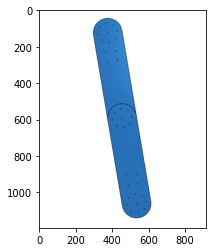

In [374]:
# load image
img = cv2.imread("/Users/nasheed-x/Desktop/Orientation/orange3.jpeg")

#cv2.imshow("Image",img)
plt.imshow(img)

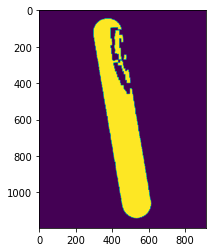

In [375]:
#convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# lower bound and upper bound for orange color
lower_bound = np.array([5,50,50])
upper_bound = np.array([15,255,255])

#find color within the boundaries
mask = cv2.inRange(hsv, lower_bound, upper_bound)

#define kernel size  
kernel = np.ones((9,9),np.uint8)

# remove unnecessary noise from mask
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

plt.imshow(mask)

In [376]:
#create canvas
canvas = np.zeros(img.shape)
canvas.fill(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

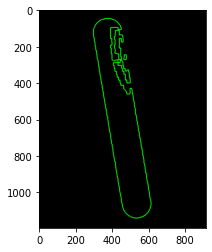

In [377]:
#create segmented image
segmented_img = cv2.bitwise_and(canvas, canvas, mask=mask)

# find contours from the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cont_output = cv2.drawContours(segmented_img, contours, -1, (0, 255, 0), 3)

plt.imshow(cont_output)
cv2.imwrite("cont_output.jpeg", cont_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

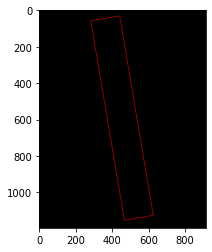

In [378]:
# get minAreaRect of contour with max area
max_area = -1

#loop through contours
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area>max_area:
            cnt = contours[i]
            max_area = area

areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]

#assign minAreaRect to contour with max area
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

#draw minAreaRect
cv2.drawContours(canvas,[box],0,(255, 0,0),2)
plt.imshow(canvas)
cv2.imwrite("cont_canvas.jpg", canvas)


In [379]:
print(rect)

((454.4833679199219, 592.2496948242188), (1109.0452880859375, 159.931884765625), 80.4186019897461)


In [ ]:
"""
Using minRectArea to get Angle
"""

#center coordinates of min_rectangle also p1
x = int(rect[0][0])
y = int(rect[0][1])

l = -300

#angle of min_rectangle
angle = rect[2] * 3.14 / 180

#get p2 based on angle
x_ = x + l * cos(angle)
y_ = y + l * sin(angle)

#get p3 based on angle
x1_ = x + l * cos(3.14)
y1_ = y + l * sin(3.14)

#define line points as int
p1 = (x,y)
p2 = (int(x_),int(y_))
p3 = (int(x1_),int(y1_))

#draw lines and circle
canvas = cv2.circle(canvas, (x,y), 20, (147,20,255), -5)
canvas = cv2.line(canvas, p1, p2, (0, 0, 255), 5)
canvas = cv2.line(canvas, p1, p3, (0, 0, 255), 5)

plt.imshow(canvas)
cv2.imwrite("fin_canvas.jpg", canvas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

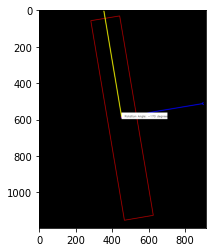

In [383]:
"""
Using getOrientation Function to Angle
"""

angle = getOrientation(cnt, canvas)
plt.imshow(canvas)
cv2.imwrite("fin_canvas.jpg", canvas)